In [13]:
# Dhananjay Tiwari,
# Graduate Student, Mechanical Engineering, Coordinated Science Laboratory, UIUC
# Created on : July 17, 2023
# This file implements clustering algorithm with inequality constraints

In [14]:
# import modules
import numpy as np # Computational python programming and not include this? Can't happen!
import matplotlib.pyplot as plt # module to make plots
from scipy.optimize import minimize # function to perform optimization
from functools import partial # to create functions with partial arguments
from scipy.optimize import SR1 # to approximate Hessians
from scipy.optimize import fsolve # to solve nonlinear equations
import time # to measure code runtime

In [15]:
# create FLP class and its associated functions
class FLP():
    # declare the class variables
    N : int # number of resources
    M : int # number of facilities
    d : int # dimension of the problem
    resLoc : np.ndarray # resource locations
    facLoc : np.ndarray # facility locations (initial)
    P : np.ndarray # association matrix between resources and facilities (P-probabilities)
    Phi : np.ndarray # probability array for inequality constraints getting satisfied (Phi-probabilities)
    ineq : str # identifier of type of inequality constraints

    # initialize the class variables
    def __init__(self, N, M, d, resLoc, facLoc, ineq):
        self.N = N
        self.M = M
        self.d = d
        self.resLoc = resLoc
        self.facLoc = facLoc
        self.P = np.ones([N, M])
        self.P = self.P / np.sum(self.P, axis = 1, keepdims=True) # normalize the P-probabilities
        self.Phi = np.ones([M, 1])*1e-5 # start with a small Phi-probabilities
        self.ineq = ineq
        print('================= Class FLP() initialized =================')

    # compute the association cost matrix between the resources and the facilities
    def association_cost_matrix(self, resLoc, facLoc, scaling_factor):
        '''
        input - self, the class instance
               resLoc: resource locations
               facLoc: facility locations
               scaling_factor: scaling factor to normalize distortion cost
        output - D: association cost matrix of size N x M
        '''
        # initialize the association cost matrix
        D = np.zeros([self.N, self.M])

        tileX = np.kron(np.ones([1,self.M]), resLoc)
        flatY = facLoc.reshape([1,self.d*self.M])
        P = tileX - flatY
        Q = np.array(np.array_split(P, self.M, axis = 1))
        D = np.transpose(np.linalg.norm(Q, axis = 2))/scaling_factor

        return D
    
    # compute the set of all inequality constraint functions
    def ineq_cons(self, num_ineq, facLoc, P):
        '''
        input - self: the class instance
                facLoc: facility locations
                string: name of inequality constraints
                P : P-probabilities
        output - vec_ineq: a vector of inequality constraints of the form - vec_ineq <= 0
                 figures: inequality constraint data for plotting 
        '''
        # initialize the inequality constraint vectors
        # num_ineq = self.M
        vec_ineq = np.zeros([num_ineq, 1])
        # circular inequality constraint
        if 'circles' == self.ineq:        
            centers = np.array([[-5,0], [15,20], [-20,-15], [-25,25]])
            radii = np.array([1,1,1,1])*3
            vec_ineq = radii - np.linalg.norm(facLoc - centers, axis = 1)
            figures = ['circles', centers, radii]
        elif 'circles1' == self.ineq:        
            centers = np.array([[-20,0], [20,0]])
            radii = np.array([1,1])*2
            vec_ineq = radii - np.linalg.norm(facLoc - centers, axis = 1)
            figures = ['circles1', centers, radii]
        
        return vec_ineq, figures
    
    # compute the vector of cluster mass inequality constraints
    def cluster_mass_cons(self, P, C, rho, num_ineq):
        ''' 
        input - P : the probability association matrix
                C : the capacity on the facilities
                rho : resource weights
                num_ineq : the total number of inequality constraints
        output - g : vector of all the inequality constraints
        '''
        # print('inside cluster_mass_cons')
        zeta = np.zeros(num_ineq)
        C_from_P = np.dot(np.transpose(P), rho)
        C_from_P = np.reshape(C_from_P, [1,num_ineq])
        # print('rho shape = ', np.shape(rho))
        # print('P shape = ', np.shape(P))
        # print('C_from_P shape = ', np.shape(C_from_P))
        zeta = C_from_P - C

        return zeta

    # compute the probability associations using gibbs distribution
    def gibbs_associations(self, facLoc, P, beta, gamma, Lambda, rho, R, C, num_ineq, D_scaling):
        '''
        input - facLoc : facility locations
                P : P-probabilities (results in implicit equations to compute P-probabilities)
                beta : annealing parameter
                gamma : inequality constraint shaping parameter
                Lambda : inequality constraint Lagrangian constants
                xi : constant to approximate tanh with sign function
                R : gradient of inequality constraint w.r.t. P-probabilities
                D_scaling : scaling factor to normalize distortion cost
        output - Phi : Phi-probabilities
                 P : P-probabilities
        '''
        # first compute Phi-probabiltiies
        # zeta, nouse = self.ineq_cons(self.M, facLoc, P)
        zeta = self.cluster_mass_cons(P, C, rho, num_ineq) # inequality vectors, size : 1 x num_ineq
        # print('zeta shape = ', np.shape(zeta))
        ineq_exp_term = np.exp(np.minimum(700, -beta * np.multiply(Lambda, np.tanh(gamma*zeta)))) # size : 1 x num_ineq
        Phi = ineq_exp_term / (1 + ineq_exp_term) # size : 1 x M
        # then compute P-probabilities
        D = self.association_cost_matrix(self.resLoc, facLoc, D_scaling) # size : N x M
        Lambda_tile = np.kron(np.ones([self.N, 1]), Lambda) # size : N x M
        rho_tile = np.kron(np.ones([1,self.M]), rho) # size : N x M
        Phi_tile = np.kron(np.ones([self.N, 1]), Phi) # size : N x M
        sech_term = np.kron(np.ones([self.N, 1]), 1/np.cosh(np.maximum(-100, np.minimum(100, gamma*zeta)))**2) # size : N x M
        D_eff = D + gamma*np.multiply(
            np.divide(Lambda_tile, rho_tile),
            np.multiply(Phi_tile, np.multiply(R, sech_term))
            ) # size : N x M
        exp_term = np.maximum(1e-40, np.exp(np.minimum(700, -beta * D_eff))) # size : N x M
        sum_exp_term = np.kron(np.ones([1, self.M]), np.sum(exp_term, axis = 1, keepdims=True)) # size : N x M

        return Phi, P-exp_term/sum_exp_term
    
    # implicit solver for P-probabilities
    def solver_Probability(self, facLoc, P0, beta, gamma, Lambda, rho, R, C, num_ineq, D_scaling):
        '''
        inputs - facLoc : facility locations
                 P0 : initial P-probabilities
                 beta : annealing parameter
                 gamma : shaping parameter
                 Lambda : inequality constraint constants
                 rho : resource weights
                 R : inequality constraint gradients w.r.t. P-probabilities
                 C : capacity constraints on the clusters
                 num_ineq : number of inequality constraints
                 D_scaling : scaling factor for association costs
        outputs - Phi : Phi-probabilities
                  P : P-probabilities
        '''
        print('------ Inside solver_Probability() function ------')

        tstart = time.time()
        # define lambda function as a function of P-probabilities
        lamdba_Pb = lambda Pb : np.reshape(
            self.gibbs_associations(
            facLoc, np.reshape(Pb, (self.N, self.M)), beta, gamma, Lambda, rho, R, C, num_ineq, D_scaling
            )[1], 
            self.N*self.M)
        tLambda = time.time()
        print('time taken for Lambda_Pb definition = ' , tLambda - tstart)
        # solve for P-probabilities
        P = fsolve(lamdba_Pb, P0).reshape((self.N, self.M))
        print('time taken by fsolve = ', time.time() - tLambda)
        # get Phi-probabilities
        Phi = self.gibbs_associations(facLoc, P, beta, gamma, Lambda, rho, R, C, num_ineq, D_scaling)[0]

        return Phi, P
    
    # compute free energy
    def free_energy(self, facLoc, P, beta, gamma, Lambda, R, rho, D_scaling, C, num_ineq, pick_term):
        '''
        input - facLoc : numpy array of facility locations from previous annealing iteration
                P : P-probability matrix from previous annealing iteration
                beta : annealing parameter
                gamma : inequality constraint annealing parameter
                Lambda : inequality constraint Lagrangian constants
                xi : constant to approximate tanh with sign function
                R : gradient of inequality constraint w.r.t. P-probabilities
                rho : weights given to resources
                D_scaling : scaling factor to normalize distortion cost
                pick_term : decides which terms are zero/non-zero in the final free energy expression
        output - F : the free energy cost
        '''
        print('----- inside free_energy() function -----')
        t1 = time.time()
        F = 0 # initialize the free energy cost
        T1 = 0; T2 = 0; T3 = 0 # the four terms in free energy expression
        # solve for the probability matrices
        Phi, P = self.solver_Probability(facLoc, P, beta, gamma, Lambda, rho, R, C, num_ineq, D_scaling) # size Phi : 1 x M, size P : N x M
        t_Pbs = time.time()
        print('time taken for solver prrobability = ', t_Pbs - t1)
        # get association cost matrix
        D = self.association_cost_matrix(self.resLoc, facLoc, D_scaling) # size : N x M
        t_D = time.time()
        print('time taken for association cost matrix = ', t_D - t_Pbs)
        # compute inequality constraint vector
        # zeta, nouse = self.ineq_cons(self.M, facLoc, P)
        zeta = self.cluster_mass_cons(P, C, rho, num_ineq)
        t_zeta = time.time()
        print('time taken for inequality vector = ', t_zeta - t_D)
        # compute other matrices/vectors
        # Lambda_tile = np.kron(np.ones([self.N, 1]), Lambda) # size : N x M
        Lambda_tile = np.tile(Lambda, (self.N, 1))
        # rho_tile = np.kron(np.ones([1, num_ineq]), rho) # size : N x M
        rho_tile = np.tile(rho, (1, num_ineq))
        # Phi_tile = np.kron(np.ones([self.N, 1]), Phi) # size : N x M
        Phi_tile = np.tile(Phi, (self.N, 1))
        t_tile = time.time()
        print('time taken for tiling the matrices = ', t_tile - t_zeta)
        sech_term = np.kron(np.ones([self.N, 1]), 1/np.cosh(np.maximum(-100, np.minimum(100, gamma*zeta)))**2) # size : N x M
        sech_term = np.tile(1/np.cosh(np.maximum(-100, np.minimum(100, gamma*zeta)))**2, (self.N, 1))
        D_eff = D + gamma*np.multiply(
            np.divide(Lambda_tile, rho_tile), 
            np.multiply(Phi_tile, np.multiply(R, sech_term))
            ) # size : N x M
        exp_term = np.maximum(1e-40, np.exp(np.minimum(700, -beta * D_eff))) # size : N x M
        sum_exp_term = np.sum(exp_term, axis = 1, keepdims=True) # size : N x M
        ineq_exp_term = np.exp(np.minimum(100, -beta * np.multiply(Lambda, np.tanh(gamma*zeta)))) # size : 1 x M
        t2 = time.time()
        print('time taken for matrix computation and tiling = ', t2 - t1)
        print('time taken for matrix computation w/o tiling = ', t2 - t_tile)
        t3 = time.time()
        # term 1 : inequality sec hyperbolic
        T1 = -gamma * np.sum(np.dot(
            np.multiply(Phi, np.multiply(Lambda, 1/np.cosh(np.maximum(-100, np.minimum(100, gamma*zeta)))**2)), 
            np.multiply(R, P).T)
            )
        t4 = time.time()
        print('time taken for T1 computation = ', t4 - t3)
        # term 2 : beta log sum exp
        T2 = -1/beta * np.dot(rho.T, np.log(sum_exp_term))[0,0]
        t5 = time.time()
        print('time taken for T2 computation = ', t5 - t4)
        # term 3 : gamma log sum exp
        T3 = -1/beta * np.sum(np.log(1+ineq_exp_term))
        t6 = time.time()
        print('time taken for T3 computation = ', t6 - t5)

        F = np.dot(np.array([T1, T2, T3]), pick_term)
        
        return F

    # objective function as a function of one-dimensional array of facility locations
    def objective(self, y, P, beta, gamma, Lambda, R, rho, D_scaling, C, num_ineq, pick_term):
        '''
        input - y : facility locations, size : 1 x 2*M
                P : P-probabilities 
                beta : annealing parameter
                gamma : inequality constraint annealing parameter
                Lambda : inequality constraint Lagrangian constants
                xi : constant to approximate tanh with sign function
                R : gradient of inequality constraint w.r.t. P-probabilities
                rho : weights given to resources
                D_scaling : scaling factor to normalize distortion cost
                C : capacity constraint array
                num_ineq : number of inquality constraints
                pick_term : pick terms in the free energy
        output - free energy cost
        '''
        # print('----- Inside objective() function -----')
        return self.free_energy(y.reshape((self.M, self.d)), P,
                                beta, gamma, Lambda, R, rho, D_scaling,
                                C, num_ineq, pick_term)


In [16]:
# define functions to assist the implementation

# function to initialize various testcases
def testcases(tc_name):
    ''' 
    input - tc_name: name of the testcase
    output - N: number of resources
             M: number of facilities
             resLoc: resource locations
             facLoc: facility locations (initial)
    '''
    if 'small_tc_160_4' == tc_name :
        d = 2 # dimension of the coordinates
        N = 320 # number of resources
        M = 8 # number of facilties
        mean = [np.array([-5,0]), np.array([15,20]), np.array([-20,-15]), np.array([-25,25]),
                np.array([5,0]), np.array([-15,-20]), np.array([20,15]), np.array([25,-25])] # cluster means
        cov = [np.array([[5, 0],[0, 5]])*10,
               np.array([[5, 0],[0, 5]])*10,
               np.array([[5, 0],[0, 5]])*10,
               np.array([[5, 0],[0, 5]])*10,
               np.array([[5, 0],[0, 5]])*10,
               np.array([[5, 0],[0, 5]])*10,
               np.array([[5, 0],[0, 5]])*10,
               np.array([[5, 0],[0, 5]])*10] # cluster covariances
        split = np.array([48, 32, 36, 44, 48, 32, 36, 44]) # no of points in every cluster
        C = np.array([48, 32, 36, 44, 48, 32, 36, 44]) # the capacity of the clusters; C <= split
        resLoc = np.zeros([N, d]) # initialize resource locations
        res_mean = np.zeros([len(mean), d]) # initialize resource mean locations
        facLoc = np.ones([M, d])*5*np.sqrt(2) # intiialize facility locations
        # generate resource and facility locations using normal distribution
        cnt = 0
        for i in range(len(mean)):
            resLoc[cnt:cnt+split[i], :] = np.random.multivariate_normal(mean[i], cov[i], split[i])
            res_mean[i,:] = np.sum(resLoc[cnt:cnt+split[i], :], axis=0)/len(resLoc[cnt:cnt+split[i], :])
            cnt = cnt + split[i]
    elif 'small_tc_43_2' == tc_name :
        d = 2 # dimension of the coordinates
        N = 43 # number of resources
        M = 2 # number of facilties
        mean = [np.array([-15,0]), np.array([15,0])] # cluster means
        cov = [np.array([[5, 0],[0, 5]])*5,
               np.array([[5, 0],[0, 5]])*5] # cluster covariances
        split = np.array([21, 22]) # no of points in every cluster
        C = np.array([21, 15]) # the capacity of the clusters; C <= split
        resLoc = np.zeros([N, d]) # initialize resource locations
        res_mean = np.zeros([len(mean), d]) # initialize resource mean locations
        facLoc = np.ones([M, d])*0 # intiialize facility locations
        # generate resource and facility locations using normal distribution
        cnt = 0
        for i in range(len(mean)):
            resLoc[cnt:cnt+split[i], :] = np.random.multivariate_normal(mean[i], cov[i], split[i])
            res_mean[i,:] = np.sum(resLoc[cnt:cnt+split[i], :], axis=0)/len(resLoc[cnt:cnt+split[i], :])
            cnt = cnt + split[i]

    return N, M, d, resLoc, facLoc, res_mean, C

# function to plot FLP results
def plot_flp(flp, N, M, resLoc, res_means, facLoc0, facLoc_opt):
    ''' 
    input - flp : the class instance
            N : # resources
            M : # facilities
            resLoc : resource locations
            facLoc0 : initial facility locations
            facLoc_opt : final facility locations (supposedly optimal)
            ineq_figures : data for plotting inequality constraints, datatype is variable
    output: None
    '''
    # initialize figure
    figure, axes = plt.subplots()
    # resources locations
    plt.scatter(resLoc[:, 0], resLoc[:, 1], marker = ".", color = 'orange')
    # resource means
    plt.scatter(res_means[:, 0], res_means[:, 1], marker = ".", color = 'red')
    # initial facility locations
    plt.scatter(facLoc0[:, 0], facLoc0[:, 1], marker = "+", color = 'blue')
    # final facility locations
    plt.scatter(facLoc_opt[:, 0], facLoc_opt[:, 1], marker = "+", color = 'black')
    plt.title('Facility and resource locations - N = ' + str(N) + ', M = ' + str(M))
    # plt.legend(['resources', 'cluster means', 'initial facilities', 'optimal facilities'])

    plt.grid()
    plt.show()
    return None

# function to plot the inequality constraints
def plot_capacity_constr(flp, P, C, rho, num_ineq):
    '''
    input - flp : flp class instance
            P : P-probability matrix
            C : array of capacity constraints
            rho : resource weights
            num_ineq : the number of inequality constraints
    output - None
    '''
    zeta = flp.cluster_mass_cons(P, C, rho, num_ineq)
    print(zeta)
    print(np.arange(num_ineq).reshape([1,num_ineq]))
    # initialize figure
    figure, axes = plt.subplots()
    # plot the zeta values (they all should be less than zero)
    plt.plot(np.arange(num_ineq).reshape([1,num_ineq])[0,:], zeta[0,:], 
             marker=".", color='black')
    plt.title('Plot of capacity constraints')
    plt.xlabel('constraint indices')
    plt.ylabel('zeta values')
    plt.grid()
    plt.show()
    return None

In [17]:
# implement the FLP algorithm on a 2D example problem
print(' ================ Small Testcase 1 ================ ')
N, M, d, resLoc, facLoc0, res_means, C = testcases('small_tc_160_4')
centroid = np.sum(resLoc, axis = 0)/len(resLoc)
ineq = 'circles1'
print('centroid = ' , centroid)


 ================ Small Testcase 1 ================ 
centroid =  [-0.33641793 -0.14162569]


In [18]:
# initialize the FLP class
flp = FLP(N, M, d, resLoc, facLoc0, ineq)

# Initialize the annealing parameters/constants/weights
rho = np.ones([N,1]) # resource weights/ uniform for now
# generate sequence of annealing parameters
numBeta = 10; beta0 = 1e-7; rBeta = 10 # total number of beta iterations, initial beta, geometric ratio
Beta = [beta0 * rBeta ** i for i in range(numBeta)] # sequence of beta-parameters
numGamma = 7; gamma0 = 1e-5; rGamma = 10 # total number of beta iterations, initial beta, geometric ratio
Gamma = [gamma0 * rGamma ** i for i in range(numGamma)] # sequence of beta-parameters
print('beta = ' , Beta)
print('gamma = ', Gamma)
num_ineq = M # the number of inequality constraints
Lambda = np.ones([1,num_ineq])*100 # inequality term penalty coefficients
R = np.zeros([N, M]) # gradient of inequalities w.r.t. probability associations
D_scaling = 1 # scaling factor to normalize distortion cost
zeta = flp.cluster_mass_cons(
    flp.solver_Probability(
        facLoc0, flp.P, Beta[0], Gamma[0], Lambda, rho, R, C, num_ineq, D_scaling
        )[1], 
    C, rho, num_ineq) # initial inequality constraint vector

# initial facility locations
y = facLoc0.reshape(flp.d*flp.M)
# annealing w.r.t. beta
print('\n ------------------------------------ \n', 'beta = ', Beta[0], 'gamma = ' , Gamma[0])
t0 = time.time()
# flp.objective(y, flp.P, Beta[0], Gamma[0], Lambda,
#               R, rho, D_scaling, C, num_ineq, 
#               np.array([1,1,1]))
flp.free_energy(facLoc0, flp.P, Beta[0], Gamma[0], Lambda, 
                R, rho, D_scaling, C, num_ineq, 
                np.array([1,1,1]))
tf = time.time()
print('time taken for objective computation = ', tf - t0)

# for beta in Beta:
#     # annealing w.r.t. gamma
#     for gamma in Gamma:
#         # optimize free energy w.r.t. facility locations
#         # using Powell method
#         # res = minimize(flp.objective, y, method='powell',
#         #               args=(flp.P, beta, gamma, Lambda, R, rho, D_scaling, C, num_ineq, np.array([1, 1, 1])),
#         #               options={'xtol':1e-8, 'disp':2})
#         # using Trust-constr method
#         res = minimize(flp.objective, y, method='trust-constr', jac = '2-point', hess=SR1(),
#                       args=(flp.P, beta, gamma, Lambda, R, rho, D_scaling, C, num_ineq, np.array([1, 1, 1])),
#                       options={'xtol':1e-8, 'disp':2})
#         # update facility locations and probability associations
#         y = res['x']
#         flp.facLoc = y.reshape((flp.M, flp.d))
#         flp.Phi, flp.P = flp.solver_Probability(flp.facLoc, flp.P, beta, gamma, Lambda, rho, R, C, num_ineq, D_scaling)



================= Class FLP() initialized =================
beta =  [1e-07, 1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.09999999999999999, 1.0, 10.0, 100.0]
gamma =  [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
------ Inside solver_Probability() function ------
time taken for Lambda_Pb definition =  0.0
time taken by fsolve =  16.959873914718628

 ------------------------------------ 
 beta =  1e-07 gamma =  1e-05
----- inside free_energy() function -----
------ Inside solver_Probability() function ------
time taken for Lambda_Pb definition =  1.1920928955078125e-06
time taken by fsolve =  16.917024850845337
time taken for solver prrobability =  16.917558908462524
time taken for association cost matrix =  9.393692016601562e-05
time taken for inequality vector =  1.4066696166992188e-05
time taken for tiling the matrices =  2.5272369384765625e-05
time taken for matrix computation and tiling =  16.917755126953125
time taken for matrix computation w/o tiling =  6.29

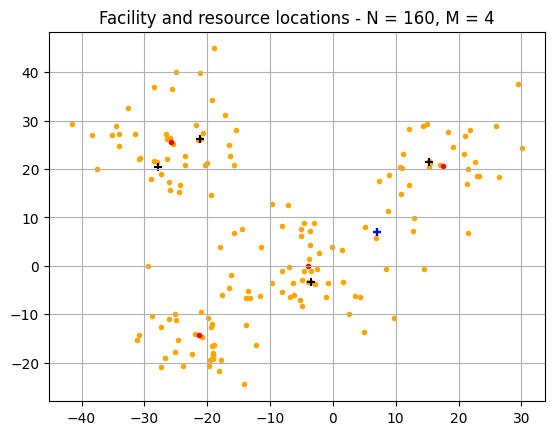

[[ 0.25019827  8.25019827 11.24940518 -1.74980173]]
[[0 1 2 3]]


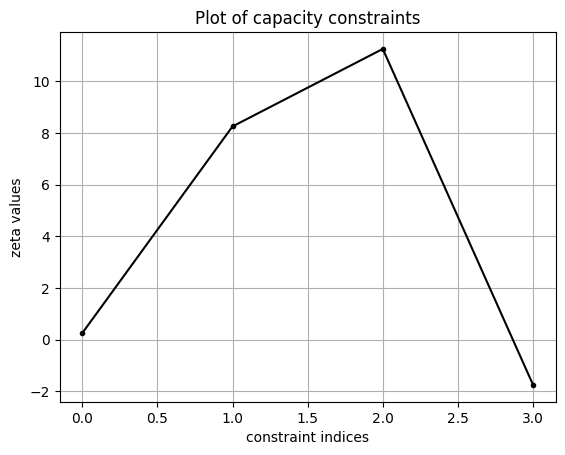

In [305]:
plot_flp(flp, N, M, resLoc, res_means, facLoc0, y.reshape((M, d)))
plot_capacity_constr(flp, flp.P, C, rho, num_ineq)

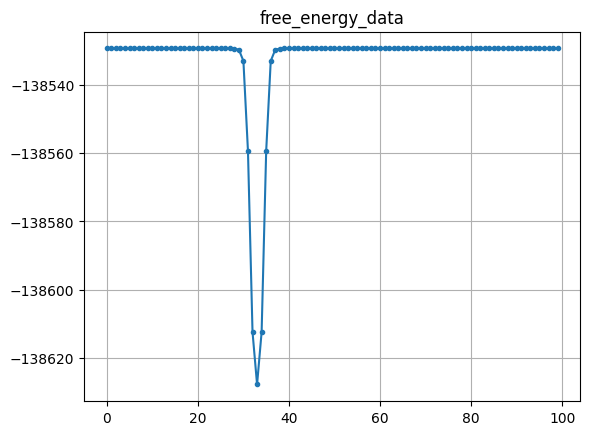

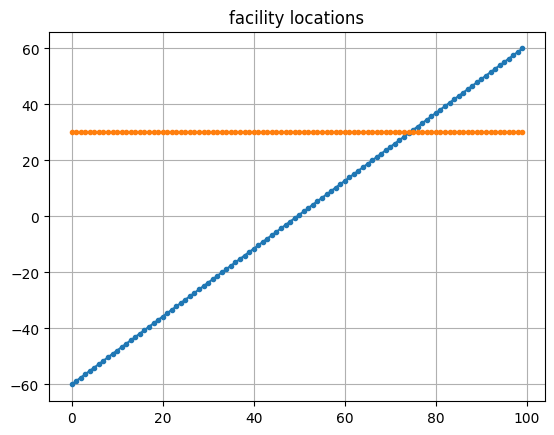

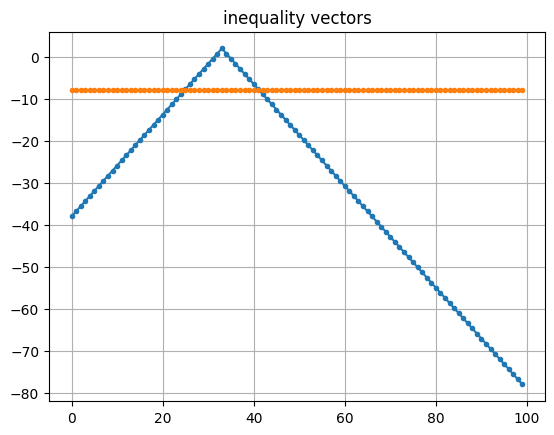

In [ ]:
# create a straight line passing along x-axis through origin
N = 100
x1 = np.linspace(-60, 60, N)
y1 = np.zeros(len(x1))
# x2 = -x1; y2 = -y1
x2 = np.ones(len(x1))*30; y2 = np.zeros(len(y1))*0
curve1 = np.transpose(np.array([x1, y1]))
curve2 = np.transpose(np.array([x2, y2]))
free_energy_data = np.zeros(len(x1))
zeta_data = np.zeros((len(x1), M))
beta = 1
gamma = 0.00001
facLoc = np.array([curve1[0], curve2[0]])
for i in range(N):
    facLoc = np.array([curve1[i], curve2[i]])
    # print(curve2[i])
    free_energy_data[i] = flp.free_energy(facLoc, beta, gamma, Lambda, xi, R, rho, D_scaling, np.array([0, 0, 1, 0]))
    zeta_data[i,:], nouse = flp.ineq_cons(facLoc)
    # print(flp.ineq_cons(facLoc))
plt.figure()
plt.plot(range(N), free_energy_data, marker = '.')
plt.title('free_energy_data')
plt.grid()
plt.figure()
plt.plot(range(N), curve1[:,0], marker = '.')
plt.plot(range(N), curve2[:,0], marker = '.')
plt.title('facility locations')
plt.grid()
plt.show()
plt.figure()
plt.plot(range(N), zeta_data[:,0], marker = '.')
plt.plot(range(N), zeta_data[:,1], marker = '.')
plt.title('inequality vectors')
plt.grid()
plt.show()


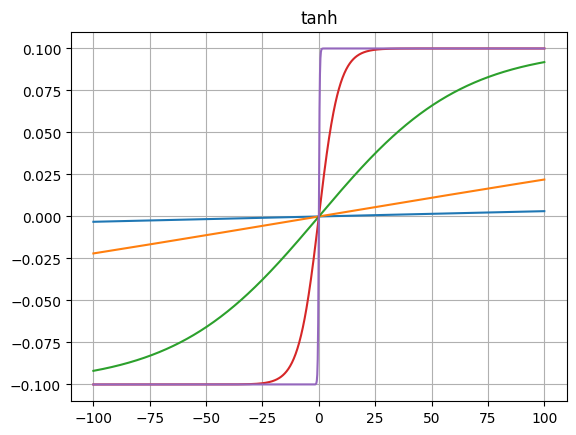

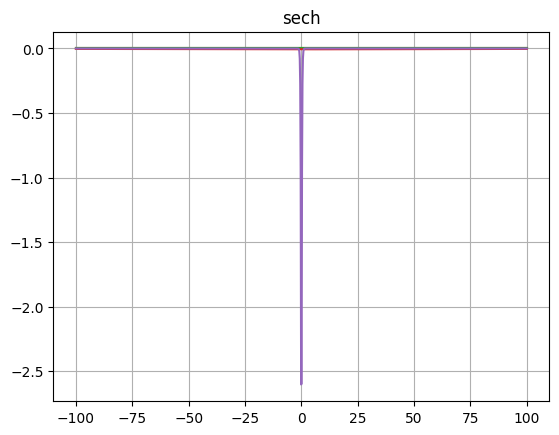

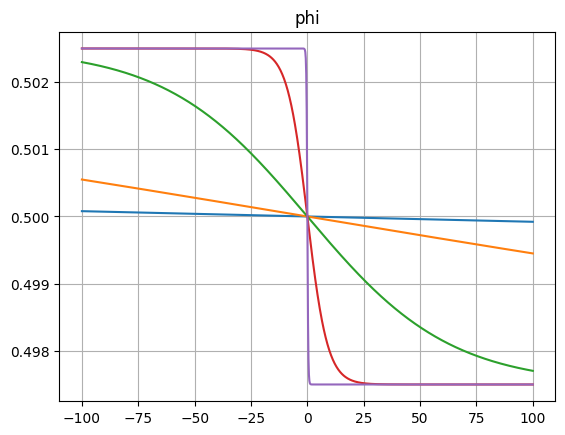

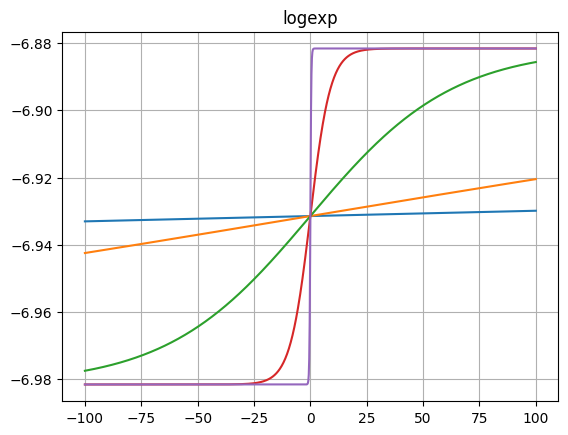

9


In [ ]:
# test block for functions

# ===========================
# function as an argument 
def apply_function(func, x):
   return func[0](x), func[1](x)
def square1(x):
   return x ** 2
def sum(x):
   return x + x
result = apply_function(np.array([square1, sum]), 3)

# ===========================
# penalty function test
def f(x, xi, beta):
   tanh = beta*np.tanh(np.sqrt(xi)*x)
   phi = np.exp(-beta*tanh) / (1 + np.exp(-beta*tanh))
   logexp = -1/beta*np.log(1 + np.exp(-beta*tanh))
   sech2 = -xi/np.cosh(xi*x) * phi
   return tanh, sech2, phi, logexp
def logsum(beta, x):
   return 1/beta*np.log(1 + np.exp(beta*x)) - np.maximum(0, x)

x = np.linspace(-100, 100, 1000)
tanh1, sech1, phi1, logexp1 = f(x, 0.0000001, 0.10)
tanh2, sech2, phi2, logexp2 = f(x, 0.0000050, 0.10)
tanh3, sech3, phi3, logexp3 = f(x, 0.0002500, 0.10)
tanh4, sech4, phi4, logexp4 = f(x, 0.0125000, 0.10)
tanh5, sech5, phi5, logexp5 = f(x, 6.2500000, 0.10)

plt.figure(1)
plt.plot(x, tanh1)
plt.plot(x, tanh2)
plt.plot(x, tanh3)
plt.plot(x, tanh4)
plt.plot(x, tanh5)
plt.title('tanh')
plt.grid()

plt.figure(2)
plt.plot(x, sech1)
plt.plot(x, sech2)
plt.plot(x, sech3)
plt.plot(x, sech4)
plt.plot(x, sech5)
plt.title('sech')
plt.grid()

plt.figure(3)
plt.plot(x, phi1)
plt.plot(x, phi2)
plt.plot(x, phi3)
plt.plot(x, phi4)
plt.plot(x, phi5)
plt.title('phi')
plt.grid()

plt.figure(4)
plt.plot(x, logexp1)
plt.plot(x, logexp2)
plt.plot(x, logexp3)
plt.plot(x, logexp4)
plt.plot(x, logexp5)
plt.title('logexp')
plt.grid()

plt.show()

# ===========================
# lambda function test
def calc(x,y):
   return x*y, x+y

lambda_calc = lambda x : calc(x, 3)[0]

print(lambda_calc(3))
